In [1]:
from pyomo.environ import *
from matplotlib import pyplot as plt
import numpy as np


from utils.model import init_model, getM1_rule
from utils.data import load_data, slope_bounds, intercept_bounds

In [2]:
data = load_data('Data/Medication.txt')

CL, CU = slope_bounds(data)
DL, DU = intercept_bounds(data)

/home/abolfazl/Documents/Project 2/utils/data.py:17: RuntimeWarning: invalid value encountered in divide
  slope_min = np.nanmin((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))
/home/abolfazl/Documents/Project 2/utils/data.py:18: RuntimeWarning: invalid value encountered in divide
  slope_max = np.nanmax((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))


In [10]:
b = 3
model = init_model(data)
model.b = Param(initialize=b)
model.B = RangeSet(1, b)
model.M = Param(model.I, initialize=getM1_rule(data))

model.c = Var(model.B, within=Reals, bounds=(CL, CU))
model.d = Var(model.B, within=Reals, bounds=(DL, DU))

model.e = Var(model.I, within=NonNegativeReals)
model.x = Var(model.I, model.B, within=Binary)

In [11]:
@model.Constraint(model.I, model.B)
def error_constraint_leq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] <= model.e[i] + model.M[i] * (1 - model.x[i, b])


@model.Constraint(model.I, model.B)
def error_constraint_geq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] >= -model.e[i] - model.M[i] * (1 - model.x[i, b])


@model.Constraint(model.I)
def assignment_constraint(model, i):
    return sum(model.x[i, b] for b in model.B) == 1


@model.Constraint(model.I, model.B)
def ordering_constraint(model, i, b):
    if i == model.n or b == model.b:
        return Constraint.Skip
    return model.x[i + 1, b + 1] <= model.x[i, b] + model.x[i, b + 1]


@model.Constraint(model.I)
def ordering_one_constraint(model, i):
    if i == model.n:
        return Constraint.Skip
    return model.x[i + 1, 1] <= model.x[i, 1]


@model.Constraint(model.I)
def ordering_last_constraint(model, i):
    if i == model.n:
        return Constraint.Skip
    return model.x[i, model.b] <= model.x[i + 1, model.b]

model.obj = Objective(expr=sum(model.e[i] for i in model.I))

In [12]:
result = SolverFactory('glpk', tee=True, keepfiles=False).solve(model)

if result.solver.termination_condition != TerminationCondition.optimal:
    raise Exception('Solver did not find an optimal solution')

print(f'Objective: {model.obj():.2f}')

Objective: 7.86


In [13]:
data_clusters = np.array([sum(model.x[i, b].value * (b - 1) for b in model.B) for i in model.I])
clusters_min = [np.min(data[data_clusters == i - 1, 0]) for i in model.B]
clusters_max = [np.max(data[data_clusters == i - 1, 0]) for i in model.B]

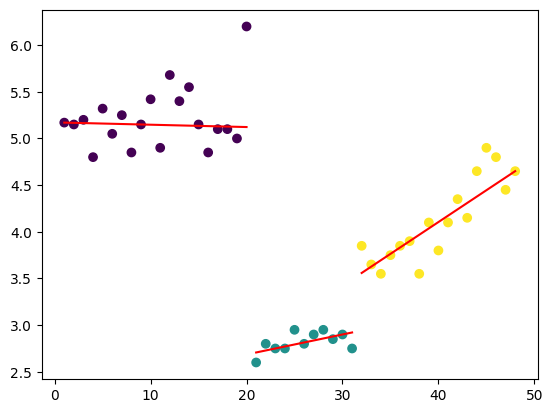

In [14]:
plt.scatter(data[:, 0], data[:, 1], c=data_clusters)
for b in model.B:
    plt.plot([clusters_min[b - 1], clusters_max[b - 1]], [model.c[b].value * clusters_min[b - 1] + model.d[b].value, model.c[b].value * clusters_max[b - 1] + model.d[b].value], color='red')
plt.show()